In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load datasets
try:
    ratings_df = pd.read_csv("ratings.csv")
    movies_df = pd.read_csv("movies.csv")
    print("Successfully loaded MovieLens dataset")
except FileNotFoundError:
    print("ERROR: Dataset files not found.")
    exit()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully loaded MovieLens dataset


In [2]:
movieID_to_idx_title = {}
for i in range(len(movies_df)):
    movieID_to_idx_title[movies_df["movieId"][i]] = (i, movies_df["title"][i])

ratings = {}
for i in range(len(ratings_df)):
    u = ratings_df["userId"][i] - 1
    m = movieID_to_idx_title[ratings_df["movieId"][i]][0]
    r = ratings_df["rating"][i]
    ratings[(u, m)] = r

data = [(user, movie, rating) for (user, movie), rating in ratings.items()]
train_ratings, test_ratings = train_test_split(data, test_size=0.2, random_state=10)


In [3]:
# ratings input: list of (i, j, r_ij) tuples
def model(ratings, n_users, m_movies, k):
    # Priors for user latent factors and bias
    with pyro.plate("users", n_users):
        nu = pyro.sample("nu", dist.Normal(0., 0.1))
        U = pyro.sample("U", dist.MultivariateNormal(torch.zeros(k), torch.eye(k)))
    
    # Priors for movie latent factors and bias
    with pyro.plate("movies", m_movies):
        mu = pyro.sample("mu", dist.Normal(0., 0.316))
        V = pyro.sample("V", dist.MultivariateNormal(torch.zeros(k), torch.eye(k)))
    
    sigma = 0.5  # observation noise

    # Plate over observed ratings
    with pyro.plate("observe_data", len(ratings)):
        user = torch.tensor([r[0] for r in ratings])
        movie = torch.tensor([r[1] for r in ratings])
        observed_rating = torch.tensor([r[2] for r in ratings])

        pred = nu[user] + mu[movie] + torch.sum(U[user] * V[movie], dim=1)
        pyro.sample("obs", dist.Normal(pred, sigma), obs=observed_rating)

In [4]:
def guide(ratings, n_users, m_movies, k):
    # User bias and latent vectors
    nu_loc = pyro.param("nu_loc", torch.zeros(n_users))
    nu_scale = pyro.param("nu_scale", torch.ones(n_users), constraint=dist.constraints.positive)

    U_loc = pyro.param("U_loc", torch.randn(n_users, k))
    U_cov = pyro.param("U_cov", torch.stack([0.1 * torch.eye(k) for _ in range(n_users)]),
                       constraint=dist.constraints.positive_definite)
    with pyro.plate("users", n_users):
        pyro.sample("nu", dist.Normal(nu_loc, nu_scale))
        pyro.sample("U", dist.MultivariateNormal(U_loc, U_cov.to(dtype=torch.float32)))

    # Movie bias and latent vectors
    mu_loc = pyro.param("mu_loc", torch.zeros(m_movies))
    mu_scale = pyro.param("mu_scale", torch.ones(m_movies), constraint=dist.constraints.positive)

    V_loc = pyro.param("V_loc", torch.randn(m_movies, k))
    V_cov = pyro.param("V_cov", torch.stack([0.1 * torch.eye(k) for _ in range(m_movies)]),
                       constraint=dist.constraints.positive_definite)
    with pyro.plate("movies", m_movies):
        pyro.sample("mu", dist.Normal(mu_loc, mu_scale))
        pyro.sample("V", dist.MultivariateNormal(V_loc, V_cov.to(dtype=torch.float32)))

In [5]:
def train_svi(train_ratings, n_users, m_movies, k, num_steps=2000, lr=0.01):
    pyro.clear_param_store()
    optimizer = Adam({"lr": lr})
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

    for step in range(num_steps):
        loss = svi.step(train_ratings, n_users, m_movies, k)
        if (step + 1) % 100 == 0:
            print(f"Step {step} - ELBO loss: {loss:.2f}")

def predict(i, j, k):
    # Extract learned variational parameters
    nu_i = pyro.param("nu_loc")[i]
    mu_j = pyro.param("mu_loc")[j]
    U_i = pyro.param("U_loc")[i]
    V_j = pyro.param("V_loc")[j]
    return (U_i @ V_j + nu_i + mu_j).item()

def predict_with_uncertainty(i, j, k):
    # Means
    nu_i = pyro.param("nu_loc")[i]
    mu_j = pyro.param("mu_loc")[j]
    U_i = pyro.param("U_loc")[i]
    V_j = pyro.param("V_loc")[j]

    # Covariances
    U_cov_i = pyro.param("U_cov")[i]
    V_cov_j = pyro.param("V_cov")[j]

    # Predictive mean
    pred_mean = (U_i @ V_j + nu_i + mu_j)

    var = (
        U_i @ V_cov_j @ U_i
        + V_j @ U_cov_i @ V_j
        + 0.25  # observation noise squared (sigma^2 = 0.5^2)
    )
    return pred_mean.item(), torch.sqrt(var).item()

def compute_rmse(test_ratings, k):
    preds = []
    trues = []
    for i, j, r in test_ratings:
        preds.append(predict(i, j, k))
        trues.append(r)
    preds = torch.tensor(preds)
    trues = torch.tensor(trues)
    return torch.sqrt(torch.mean((preds - trues) ** 2)).item()

# Train model
n_users = ratings_df["userId"].max()
m_movies = len(movieID_to_idx_title)
k = 2 # Latent dimensions

train_svi(train_ratings, n_users, m_movies, k)

# Evaluate
rmse = compute_rmse(test_ratings, k)
print(f"Test RMSE: {rmse:.4f}")

Step 99 - ELBO loss: 1007797.54
Step 199 - ELBO loss: 470768.11
Step 299 - ELBO loss: 353104.10
Step 399 - ELBO loss: 273325.63
Step 499 - ELBO loss: 247731.43
Step 599 - ELBO loss: 226612.37
Step 699 - ELBO loss: 211748.47
Step 799 - ELBO loss: 200787.27
Step 899 - ELBO loss: 190183.84
Step 999 - ELBO loss: 179935.68
Step 1099 - ELBO loss: 176037.52
Step 1199 - ELBO loss: 171551.41
Step 1299 - ELBO loss: 168107.18
Step 1399 - ELBO loss: 163867.50
Step 1499 - ELBO loss: 160231.88
Step 1599 - ELBO loss: 160101.61
Step 1699 - ELBO loss: 157447.47
Step 1799 - ELBO loss: 155270.10
Step 1899 - ELBO loss: 153437.68
Step 1999 - ELBO loss: 152723.23
Test RMSE: 1.0061


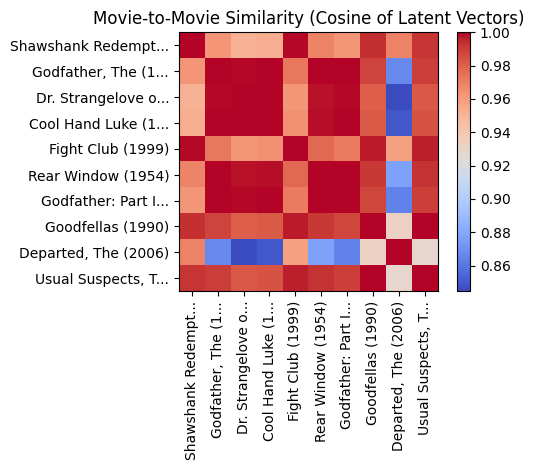

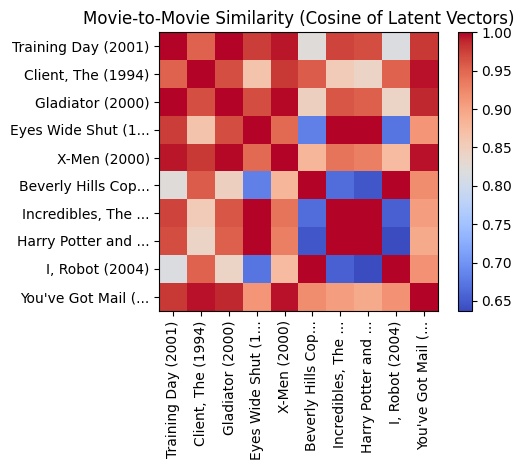

In [23]:
def plot_movie_similarity_matrix(V_loc, movie_names=None):
    # Compute cosine similarity between movie embeddings
    similarity_matrix = cosine_similarity(V_loc)

    im = plt.imshow(similarity_matrix, cmap='coolwarm', interpolation='nearest')

    # Set tick labels
    if movie_names:
        labels = [f"{name[:17]}..." if len(name) > 20 else name
                  for name in movie_names] 
    else:
        labels = [str(i) for i in range(len(V_loc))]
    plt.xticks(ticks=np.arange(len(V_loc)), labels=labels, rotation=90)
    plt.yticks(ticks=np.arange(len(V_loc)), labels=labels)

    plt.title("Movie-to-Movie Similarity (Cosine of Latent Vectors)")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

movie_popularity = ratings_df.groupby('movieId').agg({
    'rating': ['count', 'mean', 'std']
}).round(2)
movie_popularity.columns = ['num_ratings', 'avg_rating', 'rating_std']
movie_popularity = movie_popularity.reset_index()
movie_popularity = movie_popularity.merge(movies_df[['movieId', 'title']], on='movieId')
movie_popularity = movie_popularity[movie_popularity['num_ratings'] >= 50]

most_10_popular_movies = movie_popularity.nlargest(10, "avg_rating")[["movieId", "title"]]
movie_idx = [movieID_to_idx_title[movieId][0] for movieId in 
             most_10_popular_movies["movieId"]]
movie_title = [movieID_to_idx_title[movieId][1] for movieId in 
             most_10_popular_movies["movieId"]]

V_loc = pyro.param("V_loc").detach().numpy()

V_loc_10_popular = V_loc[movie_idx]
plot_movie_similarity_matrix(V_loc_10_popular, movie_title)

random_10_movies = np.random.choice(movie_popularity["movieId"], size=10, replace=False)
movie_idx = [movieID_to_idx_title[movieId][0] for movieId in random_10_movies]
movie_title = [movieID_to_idx_title[movieId][1] for movieId in random_10_movies]
V_loc_10_random = V_loc[movie_idx]
plot_movie_similarity_matrix(V_loc_10_random, movie_title)

     movieId                             title  num_ratings
314      356               Forrest Gump (1994)          329
277      318  Shawshank Redemption, The (1994)          317
257      296               Pulp Fiction (1994)          307
      movieId                    title  num_ratings
291       333         Tommy Boy (1995)           50
692       910  Some Like It Hot (1959)           50
1566     2105              Tron (1982)           50


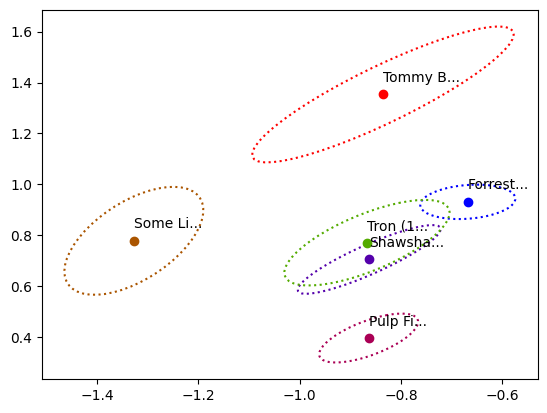

In [29]:
def draw_gaussians(means,covars,colors=None,labels=None):
    """Arguments: list of mean vectors (length-2 numpy arrays) and covariances (2x2 arrays)
    Optional args: list of colors (rgb); list of text labels
    """
    from scipy.linalg import sqrtm
    from matplotlib import colormaps
    n = len(means)
    if colors is None: cmap = colormaps['brg']; colors = [cmap(i*1./n) for i in range(n)];
    th = np.linspace(0,2*np.pi,50); circle = np.array([np.sin(th),np.cos(th)])
    for i in range(n):
        ell = (2*sqrtm(covars[i]) @ circle) + means[i].reshape(2,1)
        plt.plot(means[i][0],means[i][1],'o',ell[0,:],ell[1,:],':', color=colors[i])
    if labels is not None:
        for i in range(n): 
            plt.text(means[i][0],means[i][1]+.05,labels[i])

V_cov = pyro.param("V_cov").detach().numpy()
most_3_voted_movies = movie_popularity.nlargest(3, "num_ratings")[["movieId", "title", "num_ratings"]]
least_3_voted_movies = movie_popularity.nsmallest(3, "num_ratings")[["movieId", "title", "num_ratings"]]

movieId_6 = most_3_voted_movies["movieId"].tolist() + least_3_voted_movies["movieId"].tolist()

idx_6 = [movieID_to_idx_title[movieId][0] for movieId in movieId_6]
title_6 = [movieID_to_idx_title[movieId][1] for movieId in movieId_6]
title_6 = [f"{name[:7] + '...'}" for name in title_6]

draw_gaussians(V_loc[idx_6], V_cov[idx_6], labels=title_6)
print(most_3_voted_movies)
print(least_3_voted_movies)